In [149]:
%load_ext autoreload
%autoreload 2
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import particle as pt
from anytree import Node, RenderTree
from scipy import stats
from scipy.optimize import curve_fit

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/')
from ana_tree_class import AnaTreeAnalyzer

plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
def get_theta_phi(dcosx, dcosy, dcosz):
    """ Return theta and phi from versors
    I am keeping the geant output of theta[0, pi] and phi[-pi,pi]
    """
    theta = np.arccos(dcosz)
    if dcosx == 0:
        phi = 0
        if dcosy == 0:
            pass
        elif dcosy > 0:
            phi = np.pi/2
        elif dcosy < 0:
            phi = -np.pi/2
        return theta, phi

    phi = np.arctan(dcosy/dcosx)
    if phi == 0:
        if (dcosx > 0):
            return theta, phi
        else:
            return theta, phi+np.pi
    if phi > 0:
        if dcosx > 0:
            return theta, phi
        else:
            return theta, phi-np.pi
    else: 
        if dcosx > 0:
            return theta, phi
        else:
            return theta, np.pi+phi

In [151]:
tree = uproot.open("./anatree_hd_AV_sum.root:analysistree/anatree")

In [152]:
ana = AnaTreeAnalyzer(file="./anatree_hd_AV_sum.root:analysistree/anatree")
ana.loadTree()

In [155]:
data = ana.data
# np.sum(data["inTPCActive_geant"]==1,axis=-1)
# data["geant_list_size_geant"] - data["geant_list_size_in_tpcAV_geant"]

2301

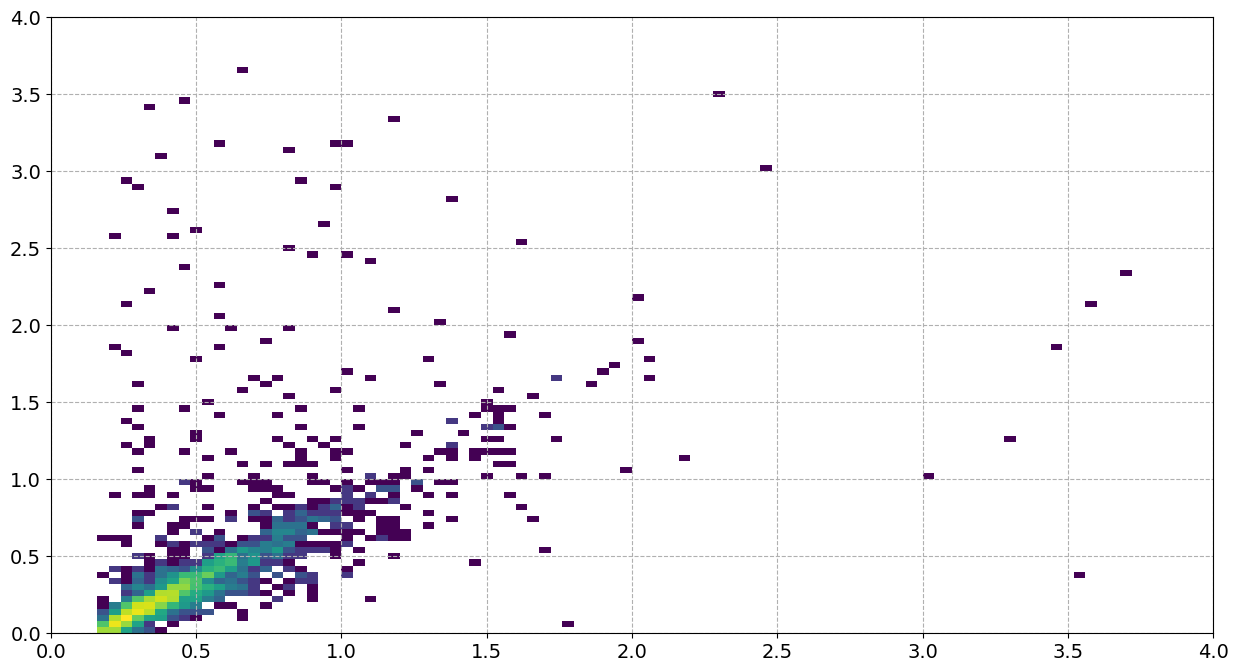

In [236]:
### Simple event selection
datanumu = data[data["nuPDG_truth"][:,0] == 14]
dataeq = datanumu[datanumu["mode_truth"][:,0] == 0]
data_cc = dataeq[dataeq["ccnc_truth"][:,0] == 0]
data_noshower = data_cc[data_cc["nshowers_pandoraShower"] != -1]
data_tracks_only = data_noshower[np.any(data_noshower["trkId_pandoraTrack"] >= 0, axis=-1)]
# data_tracks_only = data_noshower[data_noshower["ntracks_pandoraTrack"]!=0] # same but using ntracks


### Event selection for good tracks. `mask_tracks` is a jagged array that works only for tracks
mask_tracks = (data_tracks_only["trkke_pandoraTrack"] >= 0)  &\
    (data_tracks_only["trkke_pandoraTrack"] < 1e4) &\
    (abs(data_tracks_only["trkendx_pandoraTrack"]) < 300) &\
    (abs(data_tracks_only["trkendy_pandoraTrack"]) < 500) &\
    (data_tracks_only["trkendz_pandoraTrack"] < 1200) &\
    (data_tracks_only["trkendz_pandoraTrack"] > 50)


# get KE for tracks, evaluate mean value and then sum all tracks for each event
tracks_ke = np.sum(np.mean(data_tracks_only["trkke_pandoraTrack"][mask_tracks],axis=-1),axis=-1)

# Create a selection where KE was valid: empty arrays will result in tracks_ke = 0.0
mask_data = tracks_ke>0.0
tracks_ke = tracks_ke[mask_data]*1e-3 #apply delection and change to GeV
nu_en = data_tracks_only["enu_truth"][:,0][mask_data] #take nu energy for the corresponding events
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.hist2d(nu_en.to_numpy(), tracks_ke.to_numpy(), bins=100, range=[[0,4],[0,4]],cmin=1, norm='log');
len(nu_en.to_numpy())

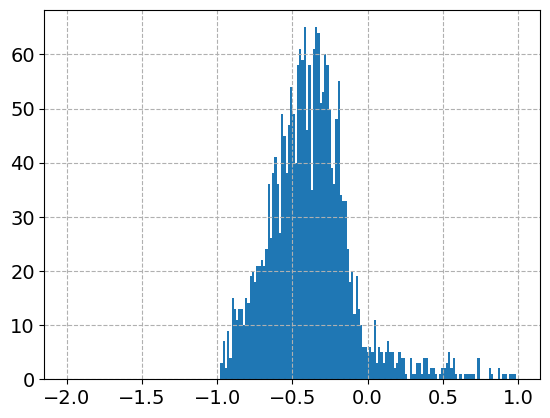

In [237]:
plt.hist(((tracks_ke-nu_en)/nu_en).to_numpy(),bins=200,range=[-2,1]);
# yikes...

###  Take pdg ID stored in the track:
1. Planes might have different ID association for some reason, I take the most frequenty one
1. I use `mask_data` as this have the events selected with a good track KE

In [238]:
data_only_valid_tracks = data_tracks_only[mask_data]
# trk_to_pdg_ids = [ for _ in data_only_valid_tracks["ntracks_pandoraTrack"]] # create empty list
### NO WAY I could do comprehensive pythonic shit here :)
trk_to_pdg_ids = []
for i, val in enumerate(data_only_valid_tracks["trkg4id_pandoraTrack"]):
    trk_to_pdg_ids.append(val)
trk_to_pdg_ids = ak.from_regular(trk_to_pdg_ids)

trk_to_pdg_ids


<Array [[1], [1], [1, 2], ..., [1], [1, 3], [1, 3]] type='2301 * var * int64'>

### The next step creates a dictionary for geant id, index and pdg code.
The `key` used is the `id`, the values are `pdg code` and `idx`  
I didn't really need this for this step. As I cicle through all the events and I could make a pdg dictionary in each one instead.. But I would like to not cicle over all events at some point and also this way the next cell I don't recreate a dictionary each time

In [239]:
idx_to_id = ana.idx_to_id_geant(data_only_valid_tracks)

In [241]:
### I check if the tracks are associated with muons and that this muons are at the vertex. If yes, I add a muon mass as correction
mass_correction = np.zeros_like(tracks_ke.to_numpy())
mask_good_muons = [False for _ in data_only_valid_tracks]
mask_good_protons = [False for _ in data_only_valid_tracks]
for i, (trkids, pdg_dict, ev) in enumerate(zip(trk_to_pdg_ids, idx_to_id, data_only_valid_tracks)):
    for trk_pdg_id in trkids:
        pdg_code = pdg_dict[trk_pdg_id][0]
        geant_idx = pdg_dict[trk_pdg_id][1]
        if abs(pdg_code) == 13 and ev["Mother_geant"][geant_idx] == 0:
            mask_good_muons[i] = True
            mass_correction[i] += 0.105

        if abs(pdg_code) == 221  and ev["Mother_geant"][geant_idx] == 0:
            print("-"*20)
            mass_correction[i] += 0.135

        if abs(pdg_code) == 2212  and ev["Mother_geant"][geant_idx] == 0:
            mask_good_protons[i] = True
            mass_correction[i] += 0.028

    # This shit was hard to debug...
    #     print(f'trk associated with pdg code: {pdg[trk_pdg_id][0]}')
    #     print(f'')
    # print(trkids)
    # print(pdg)
    # print('\n')
mass_correction = ak.from_numpy(mass_correction) ### turn it into awkward just because
mask_good_muons = mask_good_muons and mask_good_protons

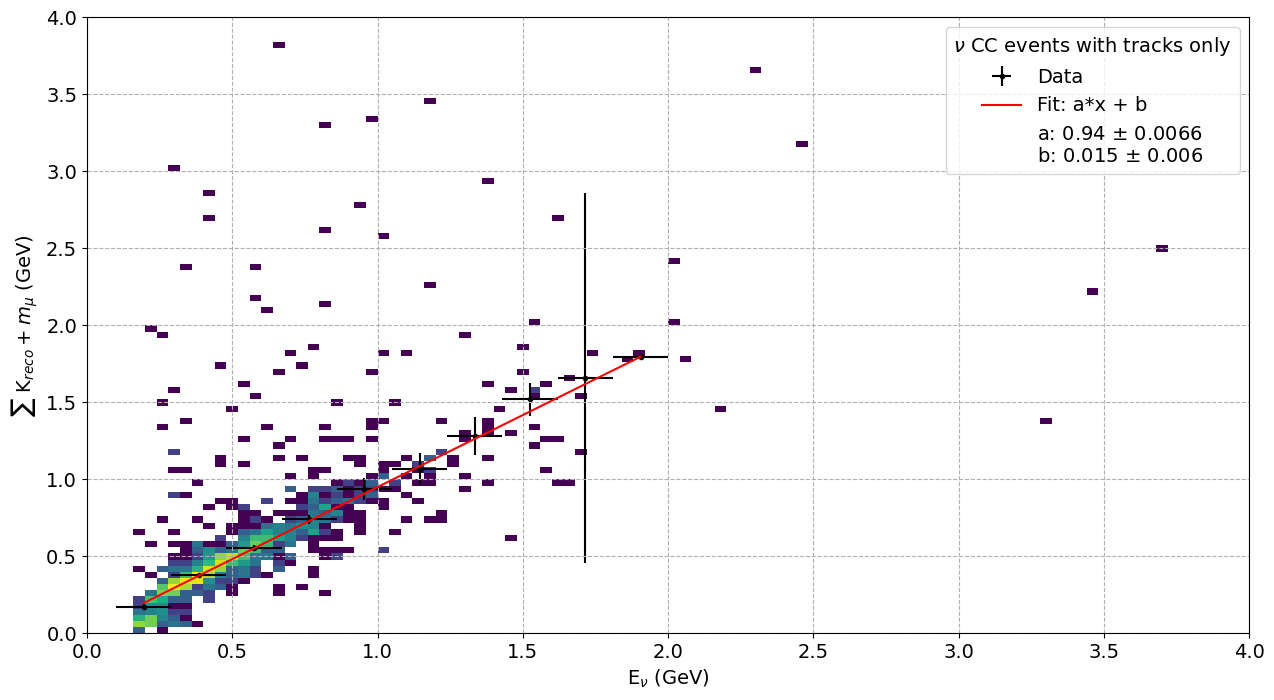

In [242]:
tracks_ke_mu = tracks_ke[mask_good_muons]
mass_correction_nu = mass_correction[mask_good_muons]
nu_en_mu = nu_en[mask_good_muons].to_numpy()
tracks_ke_mu_corrected = (tracks_ke_mu + mass_correction_nu).to_numpy() # compute better KE for track
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.hist2d(nu_en_mu, tracks_ke_mu_corrected, bins=100, range=[[0,4],[0,4]],cmin=1, norm='log');

nbins=10
nrange=[0.1,2]
bin_means, bin_edges, binnumber = stats.binned_statistic(nu_en_mu, tracks_ke_mu_corrected, statistic='median', bins=nbins, range=nrange)
bin_stds, bin_edges, binnumber = stats.binned_statistic(nu_en_mu, tracks_ke_mu_corrected, statistic='std', bins=nbins, range=nrange)
bin_counts, bin_edges, binnumber = stats.binned_statistic(nu_en_mu, tracks_ke_mu_corrected, statistic='count', bins=nbins, range=nrange)


bin_center = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1])/2

ax.errorbar(bin_center, bin_means, xerr=(bin_edges[1:]-bin_edges[:-1])/2, yerr=bin_stds/np.sqrt(bin_counts), marker='.', c='k', linestyle='', label='Data', zorder=1)
ax.set_xlabel(r"E$_\nu$ (GeV)")
ax.set_ylabel(r"$\sum$ K$_{reco} + m_\mu$ (GeV)")

def linf(x, m, b):
    return m*x + b

validdata = ~np.isnan(bin_means)
validx = bin_center[validdata]
validy = bin_means[validdata]
validyerr = bin_stds[validdata]/np.sqrt(bin_counts[validdata])
popt, pcov = curve_fit(linf, validx, validy, sigma=validyerr)
perr = np.sqrt(np.diag(pcov))

ax.plot(bin_center, linf(bin_center,*popt),  color='r', label="Fit: a*x + b", zorder=99)
label = ""
parameters = ["a", "b"]
for a, erra, pname in zip(popt,perr, parameters):
    label += f'{pname}: {a:.2} $\pm$ {erra:.2}\n'

label = label[:-2]
fplt = ax.plot([],[],' ', label=label)
ax.legend()
handles, labels = plt.gca().get_legend_handles_labels()
order=[2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=r'$\nu$ CC events with tracks only') 

array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
       -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
       -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
        0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
        0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
        0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ])

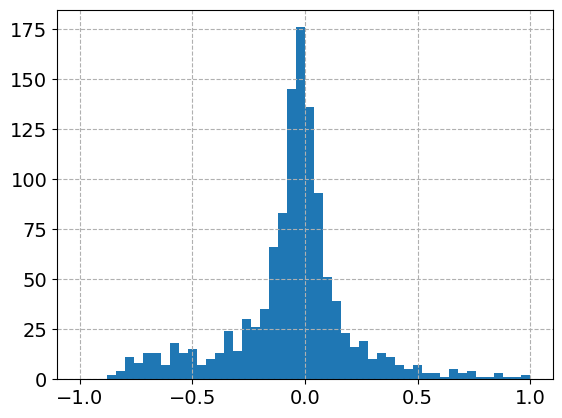

In [235]:
(n, bins, patches) = plt.hist((tracks_ke_mu_corrected-nu_en_mu)/nu_en_mu,bins=50,range=(-1,1));
datahist = ((tracks_ke_mu+mass_correction_nu-nu_en_mu)/nu_en_mu).to_numpy()
len(datahist)

bins

In [105]:
events = [i for i, _ in enumerate(data)]
events = np.array(events)

events = events[data["nuPDG_truth"][:,0] == 14]
events = events[datanumu["mode_truth"][:,0] == 0]
events = events[dataeq["ccnc_truth"][:,0] == 0]
events = events[data_cc["nshowers_pandoraShower"] == 0]
events = events[np.any(data_noshower["trkId_pandoraTrack"] >= 0, axis=-1)]
events = events[mask_data] #take nu energy for the corresponding events
len(events)

1978

['run',
 'subrun',
 'event',
 'evttime',
 'beamtime',
 'pot',
 'isdata',
 'taulife',
 'triggernumber',
 'triggertime',
 'beamgatetime',
 'triggerbits',
 'potbnb',
 'potnumitgt',
 'potnumi101',
 'nnuvtx',
 'nuvtxx',
 'nuvtxy',
 'nuvtxz',
 'nuvtxpdg',
 'kNTracker',
 'kNVertexAlgos',
 'kNShowerAlgos',
 'mcevts_truth',
 'nuPDG_truth',
 'ccnc_truth',
 'mode_truth',
 'nuWeight_truth',
 'enu_truth',
 'Q2_truth',
 'W_truth',
 'X_truth',
 'Y_truth',
 'hitnuc_truth',
 'nuvtxx_truth',
 'nuvtxy_truth',
 'nuvtxz_truth',
 'nu_dcosx_truth',
 'nu_dcosy_truth',
 'nu_dcosz_truth',
 'lep_mom_truth',
 'lep_dcosx_truth',
 'lep_dcosy_truth',
 'lep_dcosz_truth',
 'vx_flux',
 'vy_flux',
 'vz_flux',
 'pdpx_flux',
 'pdpy_flux',
 'pdpz_flux',
 'ppdxdz_flux',
 'ppdydz_flux',
 'pppz_flux',
 'ptype_flux',
 'ppvx_flux',
 'ppvy_flux',
 'ppvz_flux',
 'muparpx_flux',
 'muparpy_flux',
 'muparpz_flux',
 'mupare_flux',
 'tgen_flux',
 'tgptype_flux',
 'tgppx_flux',
 'tgppy_flux',
 'tgppz_flux',
 'tprivx_flux',
 'tprivy_flu